# Highlight

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from IPython.display import Audio

In [5]:
y, sr = librosa.load("data/New Recording 2.m4a", sr=44100)
audio = Audio(data=y, rate=sr)
audio

/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [6]:
# Low Pass Filter Version

# make the window
window_size = 11
window = np.ones(window_size)
window /= sum(window)

y_lpf = np.convolve(y, window, mode='valid')
audio = Audio(data=y_lpf, rate=sr)
audio

In [7]:
# Gaussian Low Pass
gaussian = signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

y_glpf = np.convolve(y, gaussian, mode='valid')
audio = Audio(data=y_glpf, rate=sr)
audio

# Smoothing
Smoothing is an operation that tries to remove short-term variations from a signal in order to reveal long-term trends.

Total Samples = 2359


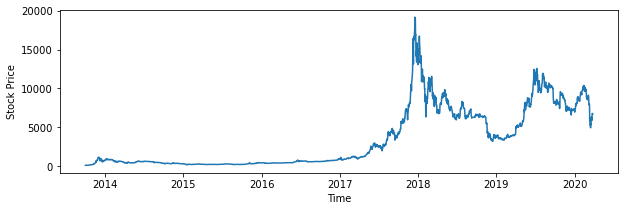

In [8]:
df = pd.read_csv('data/CoinDesk.csv')
df['Date'] = pd.to_datetime(df['Date'])
print("Total Samples = {}".format(df.shape[0]))

fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(df['Date'],df['Closing Price (USD)'])
ax.set_xlabel("Time")
ax.set_ylabel("Stock Price");

Lets create a moving average filter to smoothen the above signal.

In [9]:
window_size = 11
window = np.ones(window_size)
window /= sum(window)

In [10]:
y = np.array(df['Closing Price (USD)'])
window_padded = np.pad(window, (0,len(y)-len(window)))
np.sum(window_padded*y)

121.68011727272727

In [11]:
# repeat
rolled_window = np.roll(window_padded,1)
np.sum(rolled_window*y)

121.8867090909091

In [12]:
# repeat for the entire signal

# original signal
y = np.array(df['Closing Price (USD)'])

# create the output array, initially filled with zeros
smoothed = np.zeros(len(y))

# make the window
window_size = 11
window = np.ones(window_size)
window /= sum(window)

# pad the end of the window with zeros so its length is equal to the length of the signal you are smoothing
window_padded = np.pad(window, (0,len(y)-len(window)))

N = len(y)
rolled = window_padded
for i in range(N):
    smoothed[i] = np.sum(rolled*y)
    rolled = np.roll(rolled, 1)

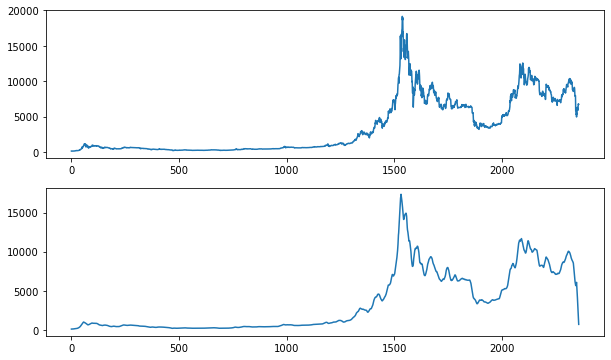

In [13]:
fig, ax  = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(y)
ax[1].plot(smoothed)

What we just did is **Correlation**, which is 
$$(f\star g)[n] = \sum_{m=0}^{N-1} f[m]g[n+m]$$ and not **Convolution**, which is$$(f\ast g)[n] = \sum_{m=0}^{N-1} f[m]g[n-m]$$

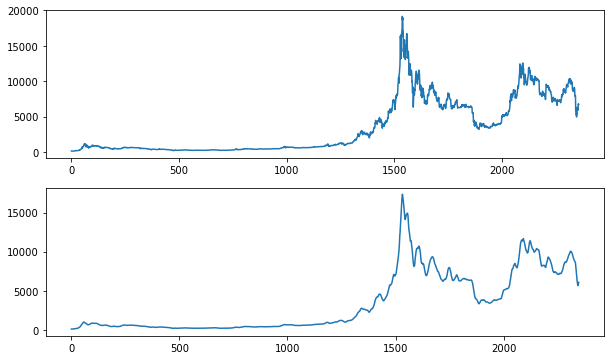

In [14]:
smoothed_y = np.convolve(y, window, mode='valid')
fig, ax  = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(y)
ax[1].plot(smoothed_y)

## More Analysis In Frequency Domain

In [15]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

(0.0, 0.01)

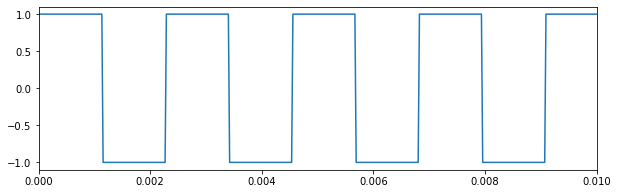

In [41]:
sr = 44100
t = np.linspace(0, 3, sr*3, endpoint=True)
squareSignal = signal.square(2 * np.pi * 440 * t)
fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(t, squareSignal)
ax.set_xlim((0,0.010))

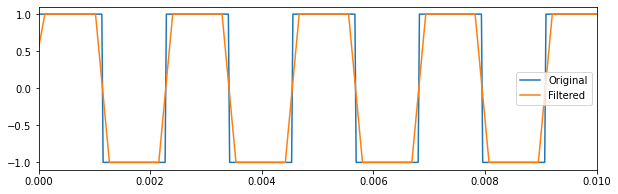

In [42]:
window = np.ones(11)
window /= sum(window)
convolved_square = np.convolve(squareSignal, window, mode='same')
fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(t, squareSignal, label="Original")
ax.plot(t, convolved_square, label="Filtered")
ax.set_xlim((0,0.010))
ax.legend();

In [44]:
audio = Audio(data=squareSignal, rate=sr)
audio

In [19]:
audio = Audio(data=convolved_square, rate=sr)
audio

Text(0, 0.5, 'Amplitude')

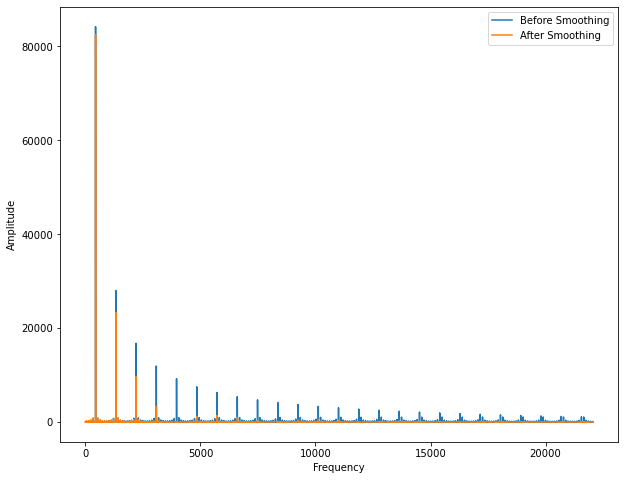

In [20]:
F_square, A_square = compute_fft(squareSignal, 44100,scale_amplitudes=False)
F_square_c, A_square_c = compute_fft(convolved_square, 44100,scale_amplitudes=False)
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_square,A_square)
ax.plot(F_square_c, A_square_c)
ax.legend(['Before Smoothing','After Smoothing'])
#ax.set_xlim((0,5000))
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude Ratio')

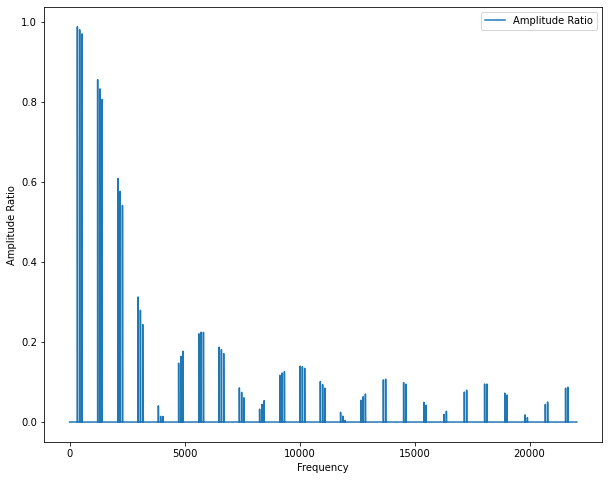

In [21]:
ratio = A_square_c/A_square
ratio[A_square<560] = 0
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_square,ratio)
ax.legend(['Amplitude Ratio'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude Ratio')
#ax.set_ylim(0,0.10)

### Why does the ratio bounce for lower amplitude ratio? 
Thats because, convolution operation means multiplication of frequency domain signals.

$$\textrm{DFT}(f \ast g) = \textrm{DFT}(f).\textrm{DFT}(g)$$
Convolution in the time domain corresponds to multiplication in the frequency domain. When we convolve a wave and a window, we multiply the spectrum of the wave with the spectrum of the window. Lets look into the spectrum of the Window

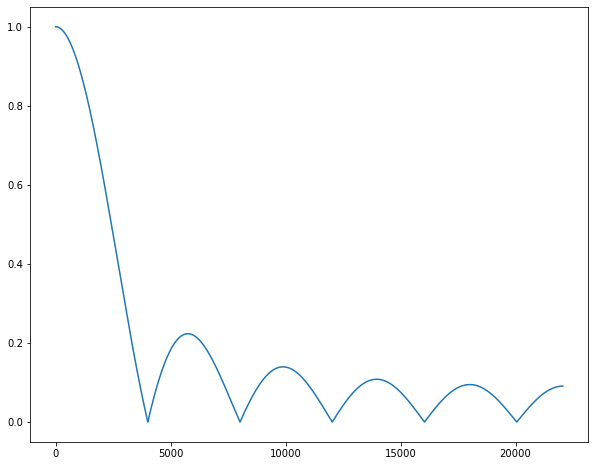

In [22]:
window_appended = np.pad(window, (0,len(squareSignal)-len(window)))
F_window, A_window = compute_fft(window_appended, 44100,scale_amplitudes=False)
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_window, A_window)

## Gaussian Filter
The moving average window we used in the previous section is a low-pass ﬁlter, but it is not a very good one. The DFT drops oﬀ steeply at ﬁrst, but then it bounces around. Those bounces are called **sidelobes**. 

(1.0, 10.0)

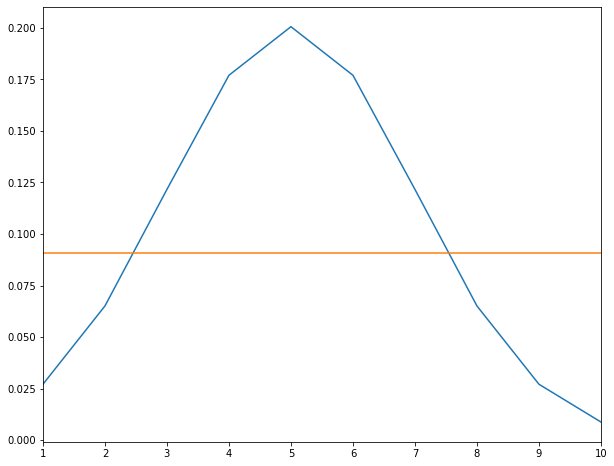

In [23]:
gaussian = signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(gaussian)
ax.plot(window)
ax.set_xlim(1,10)

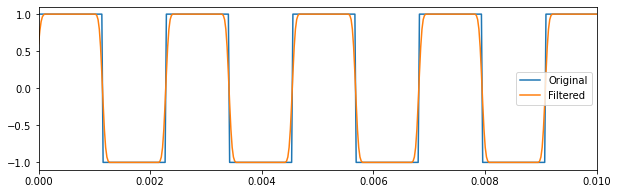

In [24]:
convolved_square = np.convolve(squareSignal, gaussian, mode='same')
fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(t, squareSignal, label="Original")
ax.plot(t, convolved_square, label="Filtered")
ax.set_xlim((0,0.010))
ax.legend();

In [25]:
audio = Audio(data=convolved_square, rate=sr)
audio

Text(0, 0.5, 'Amplitude')

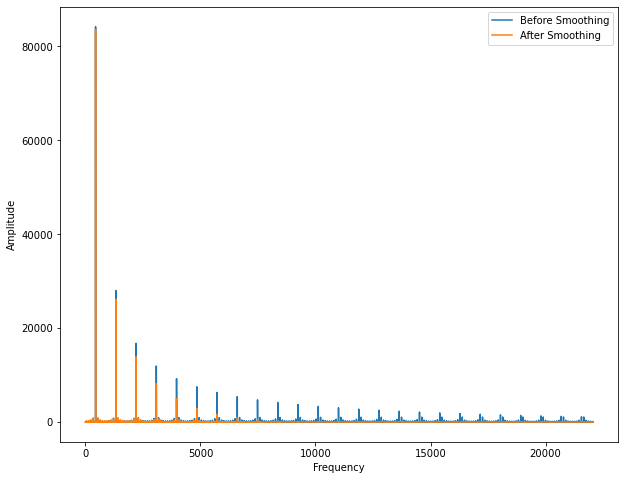

In [26]:
F_square, A_square = compute_fft(squareSignal, 44100,scale_amplitudes=False)
F_square_c, A_square_c = compute_fft(convolved_square, 44100,scale_amplitudes=False)
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_square,A_square)
ax.plot(F_square_c, A_square_c)
ax.legend(['Before Smoothing','After Smoothing'])
#ax.set_xlim((0,5000))
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude Ratio')

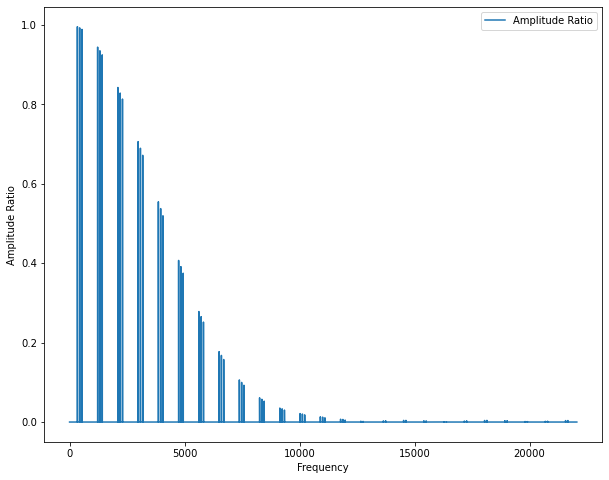

In [27]:
ratio = A_square_c/A_square
ratio[A_square<560] = 0
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_square,ratio)
ax.legend(['Amplitude Ratio'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude Ratio')
#ax.set_ylim(0,0.10)

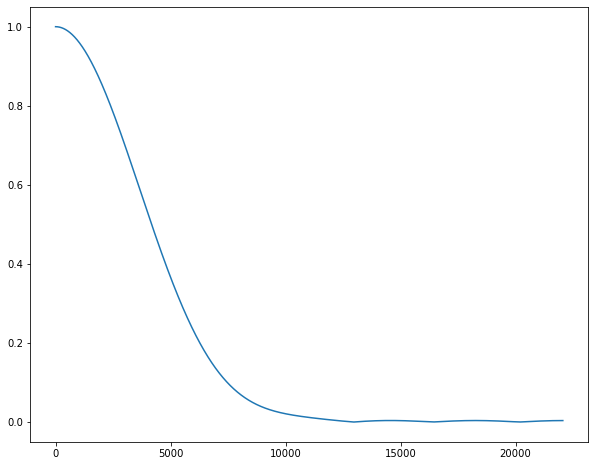

In [28]:
window_appended = np.pad(gaussian, (0,len(squareSignal)-len(window)))
F_window, A_window = compute_fft(window_appended, 44100,scale_amplitudes=False)
fig, ax  = plt.subplots(1,1, figsize=(10,8))
ax.plot(F_window, A_window)

## Eﬃcient convolution
$$\textrm{DFT}(f \ast g) = \textrm{DFT}(f).\textrm{DFT}(g)$$

So another way to compute a convolution is:

$$ (f \ast g) = \textrm{IDFT}(\textrm{DFT}(f).\textrm{DFT}(g)) $$

In [32]:
import timeit

In [33]:
df = pd.read_csv('data/CoinDesk.csv',nrows=1625, parse_dates=[0])
ys = df['Closing Price (USD)']

0.14651104200015652


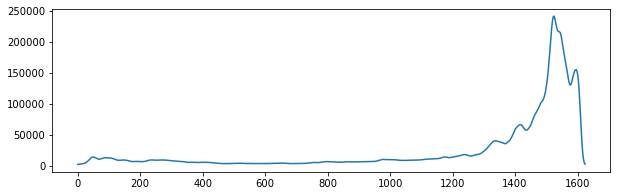

In [37]:
def usual_convolve(signal, window):
    smoothed = np.zeros(len(signal))
    window_padded = np.pad(window, (0,len(signal)-len(window)))
    N = len(signal)
    rolled = window_padded
    for i in range(N):
        smoothed[i] = np.sum(rolled*signal)
        rolled = np.roll(rolled, 1)
    return smoothed


gaussian_window = signal.gaussian(M=30, std=6)
window /= window.sum()
smoothed = usual_convolve(ys, gaussian_window)

execution_time = timeit.timeit(lambda: usual_convolve(ys, gaussian_window), number=1)

fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(smoothed)
print(execution_time)

0.0005801249999421998


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


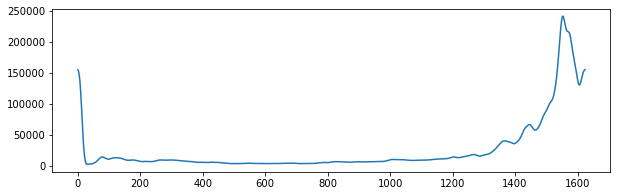

In [39]:
def fft_convolve(signal, window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal * fft_window)

padded = np.pad(gaussian_window, (0,len(ys)-len(gaussian_window)))
smoothed2 = fft_convolve(ys, padded)

execution_time = timeit.timeit(lambda: fft_convolve(ys, padded), number=1)

fig, ax  = plt.subplots(1,1, figsize=(10,3))
ax.plot(smoothed2)
print(execution_time)